Let's cluster the samples in the SwissProt GO dataset by their GO terms so we can use the cluster assignment to later do a stratified train/test split. We'll start by creating some embeddings for the terms.

/home/andrew/Workspace/AmiGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding dimensionality: 768, Explained Variance: 0.8508


Initialization 0
  Iteration 10	 time lapse 30.36683s	 ll change 1.48423
  Iteration 20	 time lapse 19.09141s	 ll change 0.20273
  Iteration 30	 time lapse 23.85374s	 ll change 0.09167
  Iteration 40	 time lapse 20.84257s	 ll change 0.02392
  Iteration 50	 time lapse 24.08076s	 ll change 0.01515
  Iteration 60	 time lapse 22.53034s	 ll change 0.07397
  Iteration 70	 time lapse 15.04514s	 ll change 0.03440
  Iteration 80	 time lapse 20.65144s	 ll change 0.00668
  Iteration 90	 time lapse 17.62728s	 ll change 0.00482
  Iteration 100	 time lapse 15.43014s	 ll change 0.00640
  Iteration 110	 time lapse 18.00338s	 ll change 0.00320
  Iteration 120	 time lapse 19.64570s	 ll change 0.02744
  Iteration 130	 time lapse 18.45433s	 ll change 0.01138
  Iteration 140	 time lapse 16.87559s	 ll change 0.00122
Initialization converged. time lapse 285.11859s	 lower bound 583.17650.


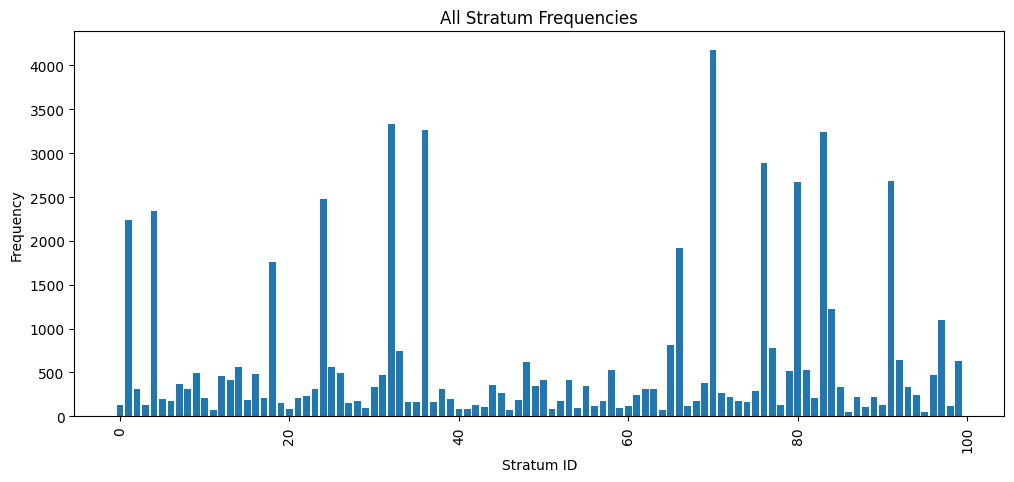



Embedding dimensionality: 256, Explained Variance: 0.8565


Initialization 0
  Iteration 10	 time lapse 24.24525s	 ll change 2.05800
  Iteration 20	 time lapse 12.76811s	 ll change 0.05363
  Iteration 30	 time lapse 12.48086s	 ll change 0.12554
  Iteration 40	 time lapse 25.53001s	 ll change 0.03602
  Iteration 50	 time lapse 17.99963s	 ll change 0.02272
  Iteration 60	 time lapse 12.66358s	 ll change 0.00916
Initialization converged. time lapse 111.77783s	 lower bound 524.41082.


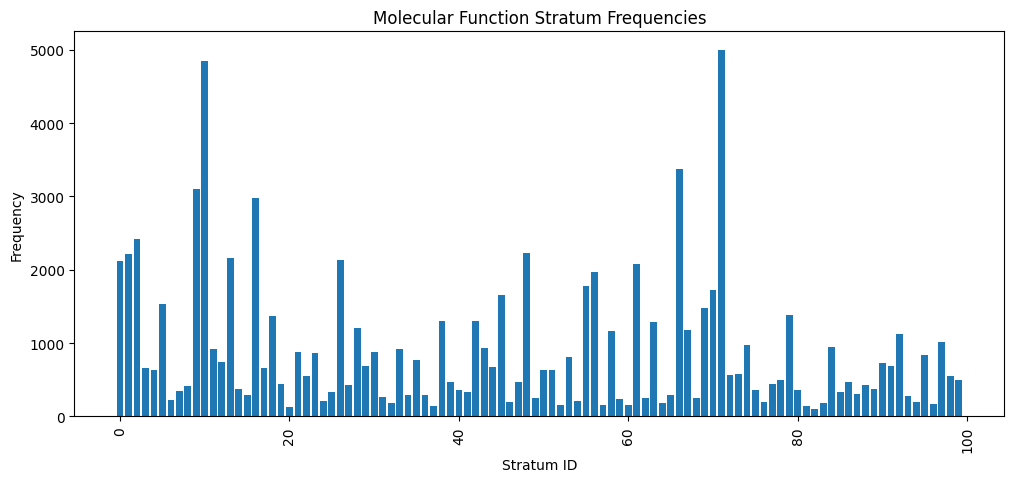



Embedding dimensionality: 512, Explained Variance: 0.8424


Initialization 0
  Iteration 10	 time lapse 23.98612s	 ll change 1.52600
  Iteration 20	 time lapse 27.07980s	 ll change 0.13938
  Iteration 30	 time lapse 19.93621s	 ll change 0.16091
  Iteration 40	 time lapse 19.69434s	 ll change 0.05802
  Iteration 50	 time lapse 24.30181s	 ll change 0.02029
  Iteration 60	 time lapse 35.40899s	 ll change 0.01393
  Iteration 70	 time lapse 20.80652s	 ll change 0.01218
  Iteration 80	 time lapse 19.50668s	 ll change 0.00800
  Iteration 90	 time lapse 18.93966s	 ll change 0.02554
  Iteration 100	 time lapse 26.08302s	 ll change 0.00839
  Iteration 110	 time lapse 25.18216s	 ll change 0.00258
Initialization converged. time lapse 269.73299s	 lower bound 576.93186.


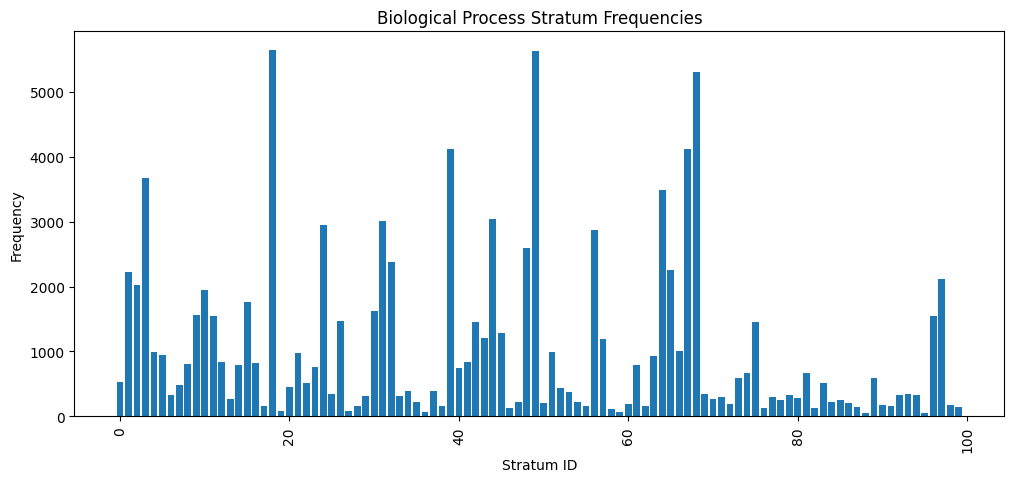



Embedding dimensionality: 128, Explained Variance: 0.8953


Initialization 0
  Iteration 10	 time lapse 10.88780s	 ll change 0.17188
  Iteration 20	 time lapse 9.58406s	 ll change 0.04834
  Iteration 30	 time lapse 9.58382s	 ll change 0.04260
  Iteration 40	 time lapse 9.57485s	 ll change 0.00426
  Iteration 50	 time lapse 9.53338s	 ll change 0.07523
  Iteration 60	 time lapse 9.50776s	 ll change 0.00838
  Iteration 70	 time lapse 9.49436s	 ll change 0.00896
  Iteration 80	 time lapse 9.55592s	 ll change 0.00076
Initialization converged. time lapse 77.72205s	 lower bound 389.36426.


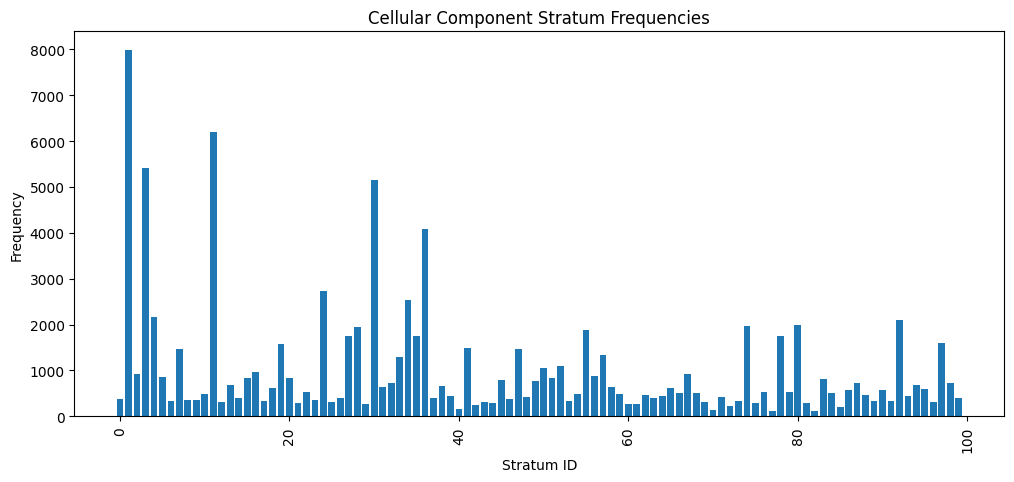

In [1]:
from functools import partial

from datasets import load_dataset

import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

from collections import Counter

import matplotlib.pyplot as plt

all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

all_dimensions = 768
mf_dimensions = 256
bp_dimensions = 512
cc_dimensions = 128

num_strata = 100

random_seed = 42

new_svd = partial(TruncatedSVD, random_state=random_seed)

new_gmm = partial(
    GaussianMixture,
    n_components=num_strata,
    covariance_type="diag",
    random_state=random_seed,
    max_iter=300,
    verbose=2,
)

all_stratum_ids = {}
mf_stratum_ids = {}
bp_stratum_ids = {}
cc_stratum_ids = {}

all_counter = Counter()
mf_counter = Counter()
bp_counter = Counter()
cc_counter = Counter()

for name, dataset_path, stratum_ids, dimensions, counter in [
    ("All", all_dataset_path, all_stratum_ids, all_dimensions, all_counter),
    ("Molecular Function", mf_dataset_path, mf_stratum_ids, mf_dimensions, mf_counter),
    ("Biological Process", bp_dataset_path, bp_stratum_ids, bp_dimensions, bp_counter),
    ("Cellular Component", cc_dataset_path, cc_stratum_ids, cc_dimensions, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    unique_terms = set()

    for record in dataset:
        for term in record["go_terms"]:
            unique_terms.add(term)

    term_index_mapping = {term: index for index, term in enumerate(unique_terms)}

    term_embeddings = {}

    for record in dataset:
        id = record["id"]

        embedding = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in record["go_terms"]:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                embedding[index] = 1

        term_embeddings[id] = embedding

    svd = new_svd(n_components=dimensions)

    x = np.stack(list(term_embeddings.values()))
    
    svd.fit(x)
    
    explained_variance = np.sum(svd.explained_variance_ratio_)

    print(f"Embedding dimensionality: {dimensions}, Explained Variance: {explained_variance:.4f}")

    z = svd.transform(x)

    for sequence_id, embedding in zip(term_embeddings.keys(), z):
        term_embeddings[sequence_id] = embedding

    print("\n")

    gmm = new_gmm()

    x = np.stack(list(term_embeddings.values()))

    predictions = gmm.fit_predict(x)

    for sequence_id, stratum_id in zip(term_embeddings.keys(), predictions):
        stratum_ids[sequence_id] = stratum_id

        counter[stratum_id] += 1

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

    print("\n")

Lastly, add the stratum IDs to the dataset, dropping any singletons, and write to disk.

In [2]:
import json

all_stratified_path = "./dataset/all-stratified.jsonl"
mf_stratified_path = "./dataset/mf-stratified.jsonl"
bp_stratified_path = "./dataset/bp-stratified.jsonl"
cc_stratified_path = "./dataset/cc-stratified.jsonl"

for dataset_path, stratified_path, stratum_ids, counter in [
    (all_dataset_path, all_stratified_path, all_stratum_ids, all_counter),
    (mf_dataset_path, mf_stratified_path, mf_stratum_ids, mf_counter),
    (bp_dataset_path, bp_stratified_path, bp_stratum_ids, bp_counter),
    (cc_dataset_path, cc_stratified_path, cc_stratum_ids, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    dropped = 0

    with open(stratified_path, "w") as file:
        for record in dataset:
            id = record["id"]
            stratum_id = stratum_ids[id]

            if counter[stratum_id] < 2:
                dropped += 1

                continue

            record["stratum_id"] = str(stratum_id)

            file.write(json.dumps(record) + "\n")

    print(f"Dropped {dropped:,} noise samples from dataset.")

    print(f"Dataset saved to {stratified_path}")

print("Done!")

Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/all-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/mf-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/bp-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/cc-stratified.jsonl
Done!
